In [2]:
from __future__ import division
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

import matplotlib.pyplot as plt

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
word_filter_len = 1 # only words above this length are considered valid
max_var_len = 1

In [4]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [5]:
model_ = torch.load('models/PHOCNet_Nov13.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [6]:
# find the file names
# f = open('../splits/val_files.txt', 'rb')
# A = f.readlines()
# f.close()
# A = [x.rstrip('\n') for x in A]
A = ['D0042-1070001']

In [7]:
from strlocale import BasicLocale

def clean_words(words):
    lc = BasicLocale()
    for i, w in enumerate(words):
        try:
            words[i] = lc.represent(w).encode('ascii',errors='ignore')
        except:
            words[i] = w
    return words

# load before, after images and words, transforms and cleans them
# the function also assumes that ground truth words are the same before and after
# returns before_images, after_images, words
def load_and_transform(map_name):
    images_before = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_regions/org_clips/'+map_name+'.npy')
    words_before = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_labels/org_clips/'+map_name+'.npy')
    words_before = clean_words(words_before)
    images_before, words_before = clean_word_images(images_before, words_before)
    images_before = np.transpose(images_before, (0,3,1,2))
    
    images_after = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_regions_new/'+map_name+'.npy')
    words_after = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_labels_new/'+map_name+'.npy')
    words_after = clean_words(words_after)
    images_after, words_after = clean_word_images(images_after, words_after)
    images_after = np.transpose(images_after, (0,3,1,2))
    
    print 'Images Before Shape ', images_before.shape
    print 'Words Before Shape ', words_before.shape
    print 'Images After Shape ', images_after.shape
    print 'Words After Shape ', words_after.shape
    return images_before, images_after, words_after

def clean_word_images(images, words):
    selected_idx = [x for x in range(len(words)) if len(words[x]) > word_filter_len]
    images = images[selected_idx]
    words = words[selected_idx]
    return images, words

In [8]:
images_before, images_after, words = load_and_transform(A[0])

Images Before Shape  (1078, 3, 135, 487)
Words Before Shape  (1078,)
Images After Shape  (1078, 3, 135, 487)
Words After Shape  (1078,)


In [18]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

outputs_before = get_image_embeddings(images_before)
outputs_after = get_image_embeddings(images_after)

100%|██████████| 1078/1078 [00:25<00:00, 41.91it/s]


In [19]:
def insert_dict_set(dct, key, val):
    if key not in dct:
        dct[key] = set()
    dct[key].add(val)
    
# the method defines the rules to handle multiple dir associated with a given word
# returns conf_words which is a set of word_var where this confusion exists
# word_var: dictionary from word -> chosen_dir. Incase a word has multiple dir
# the following preference order is followed 0 > (1,-1) > (2,-2) > (3,-3) ...
def handle_word_conf(comp_word_var):
    word_var = {}
    conf_words = set()
    for var in comp_word_var.keys():
        dirs = np.array(list(comp_word_var[var]))
        if(len(dirs) == 1):
            word_var[var] = dirs[0]
        else:
            conf_words.add(var)
            idx = np.argmin(np.abs(dirs))
            word_var[var] = dirs[idx]
    return word_var, conf_words

# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
# enable_conf: boolean flag that controls if the confusion logic should be used.
# when enabled if a word is a root word as well as a word variation (happens if root words ar rand and grand)
# it marks it as to be extended and also stores it in the confusion list
def create_word_variations(words, enable_conf=False):
    word_var = {}
    root_word_var = {}
    # create the root word variation dict and set word_var as -1 or +1
    for w in words:
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            for l in range(1,max_var_len+1):
                if len(w) <= l:
                    continue
                insert_dict_set(word_var, var, 0)
                insert_dict_set(word_var, var[l:], l)
                insert_dict_set(word_var, var[:-l], -l)
                var_set.add(var)
                var_set.add(var[l:])
                var_set.add(var[:-l])
        root_word_var[w] = var_set
    word_var, conf_words = handle_word_conf(word_var)
    return word_var, root_word_var, conf_words

In [20]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var, conf_words = create_word_variations(word_strings, enable_conf=False)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var, conf_words)

emb_info = get_word_phoc_representations(words)

100%|██████████| 1813/1813 [00:00<00:00, 4565.12it/s]

('embedding variations:', (1813, 945))


In [21]:
# gets the embeddings for images before, images after and the ground truth word embeddings
def get_emb_images_words(outputs_before, outputs_after, words, emb_info):
    embedding_var, word_var_strings, word_var_dir, root_word_var, _ = emb_info
    emb_list = []
    for i in range(len(words)):
        for j in range(len(word_var_strings)):
            if(word_var_strings[j] == words[i]):
                emb_list.append([outputs_before[i], outputs_after[i], embedding_var[j]])
                break
    return emb_list
emb_list = get_emb_images_words(outputs_before, outputs_after, words, emb_info)

In [42]:
phoc_len = 63 # number of characters supported by phoc

# function to display the heatmap
def show_heatmap(emb, title, labels):
    plt.figure(figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.xticks(np.arange(0, emb.shape[1]+1, 1), np.array(labels))
    plt.yticks(np.arange(0, emb.shape[0]+1, 1))
    # plt.title(title)
    plt.imshow(emb, cmap='binary', interpolation='nearest')
    plt.show()

# given an embedding array for an image, plots a heatmap of the embeddings
# for the actual text word, embeddings of original image and embedding
# of image after transformation (extension).
# all_embs: all the embeddings of a particular image obtained from get_emb_images_words
# word: The ground truth word
# level: The PHOC level that needs to be plotted [1,2,3,4]
# only_alphabets: boolean if True plots only alphabets on the heatmap (leaving out the digits and special characters)
def embedding_heatmap(all_embs, word, level, only_alphabets):
    if level == 1:
        l = 0
        r = phoc_len
    elif level == 2:
        l = phoc_len
        r = phoc_len*3
    elif level == 3:
        l = phoc_len*3
        r = phoc_len*7
    else:
        l = phoc_len*7
        r = phoc_len*15

    print 'Level',level,' PHOC embeddings for',word
    rows = (int)((r-l)/phoc_len)
    emb_word = all_embs[2][l:r].reshape(rows,phoc_len)
    # emb_before = all_embs[0][l:r].reshape(rows,phoc_len)
    # emb_after = all_embs[1][l:r].reshape(rows,phoc_len)

    if only_alphabets:
        unigrams = [chr(i) for i in range(ord('A'), ord('Z')+1) + range(ord('a'), ord('z') + 1)]
        lidx = 1
        ridx = 53
    else:
        unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
        lidx = 0
        ridx = 63
    
    show_heatmap(emb_word[:,lidx:ridx], 'Heatmap for word text embedding', unigrams)
    # show_heatmap(emb_before[:,lidx:ridx], 'Heatmap for before image embedding', unigrams)
    # show_heatmap(emb_after[:,lidx:ridx], 'Heatmap for after image embedding', unigrams)

## Plot Description
* Three plots will be made
    * Heatmap for word text embedding
    * Heatmap for before image embedding
    * Heatmap for after image embedding
* Each plot may be nxd depending on the level being visualized e.g At level 1, n=1. At level 2, n=2, At level 3, n=4 and at level 4, n=8
* Black squares on the heatmap represent 1, while white squares represent 0, and greys the values in between
* embedding_heatmap plots the embedding. Just use the index of images to get embeddings and ground truth word to pass into embedding_heatmap. Image indexes can be found from the last celll in the notebook. e.g The below cell plots embeddings for RANDOLPH (index 22) at level 1.

## Analysis
* Still working on analyzing the embeddings
* Some things that I could observe is that the embeddings in general become more noisy (deviate more from ground truth embedding) after the extension was done

Level 1  PHOC embeddings for CRAWFORD


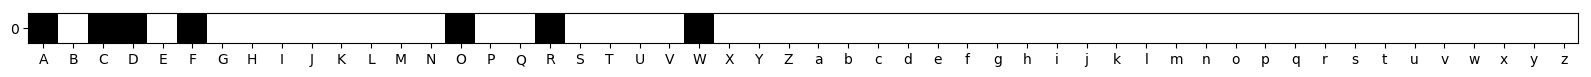

Level 2  PHOC embeddings for CRAWFORD


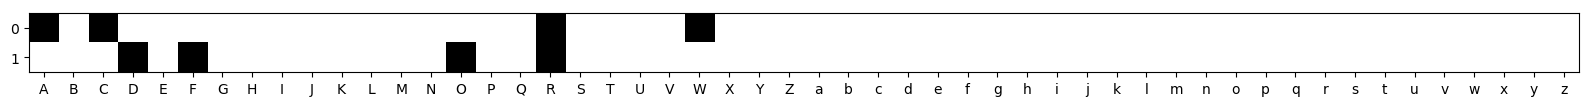

Level 4  PHOC embeddings for CRAWFORD


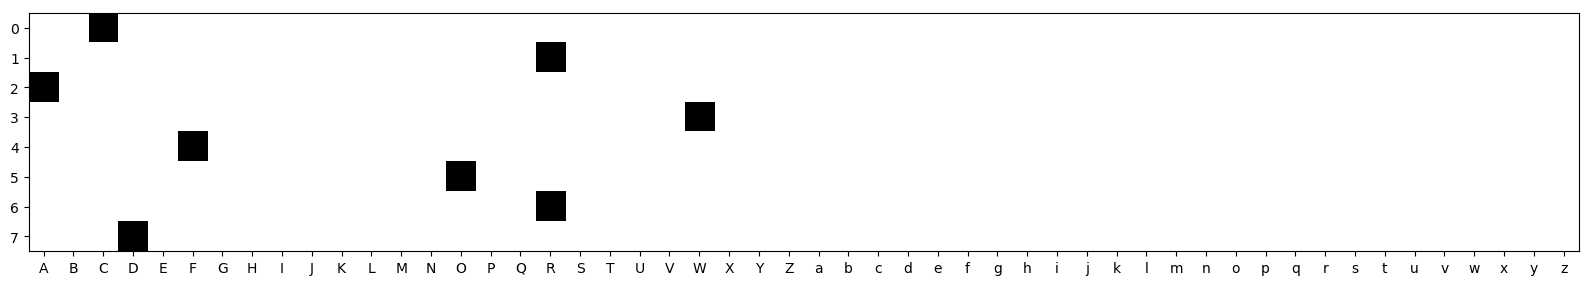

In [44]:
# print(len(emb_list), len(words))
embedding_heatmap(emb_list[90], words[90], 1, True)
embedding_heatmap(emb_list[90], words[90], 2, True)
embedding_heatmap(emb_list[90], words[90], 4, True)

In [36]:
from scipy.spatial.distance import cdist, pdist, squareform

# gets the actual distances of all the ground truth word variations
def get_all_dist_gt(dist_mat, emb_info, words):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    all_dist = []
    for i in range(len(words)):
        w_dist = []
        w_vars = root_word_var[words[i]]
        for j in range(len(word_var_strings)):
            if word_var_strings[j] in w_vars:
                w_dist.append((word_var_strings[j], dist_mat[i][j]))
        all_dist.append(w_dist)
    return all_dist

# the new report matches method that handles variations
def report_matches_with_variations(dist_mat, word_strings, emb_info, k):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    gt_words_dist = get_all_dist_gt(dist_mat, emb_info, word_strings)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    actual_dist = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            actual_dist.append(dist_mat[i][j])
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    is_correct = []
    for i in range(len(word_strings)):
        is_correct.append(0)
        if word_strings[i].lower() in [mw.lower() for mw in matched_words[i]]:
            is_correct[i] = 1
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    is_correct[i] = 2
                    count = count+1
                    break
    return (count, matched_words, img_dir, words_len, actual_dist, is_correct, gt_words_dist)

# For some images, the original predicted word os both a root word and a word_variation of another word 
# (common word problem). Due to this one cannot be sure, if these images should be extended or not.
# These images are handled by comparing distances before and after image extension and picking the minimum one
# the feature can be turned of by setting enable_conf = False
def update_dist_matrix(dist_mat_before, dist_mat_after, conf_idx):
    print('conf_idx', conf_idx)
    for i in conf_idx:
        dist = np.minimum(dist_mat_before[i], dist_mat_after[i])
        dist_mat_after[i] = dist

In [37]:
# get the distance between images and words
dist_matrix_before = cdist(XA=outputs_before, XB=emb_info[0], metric='cosine')
dist_matrix_after = cdist(XA=outputs_after, XB=emb_info[0], metric='cosine')
# get the matches report
match_report_before = report_matches_with_variations(dist_matrix_before,words,emb_info,1)
# get index of low confidence images
conf_idx = [i for i in range(len(match_report_before[1])) if match_report_before[1][i][0] in emb_info[4]]
# update the dist_after matrix based for low confidence images
update_dist_matrix(dist_matrix_before, dist_matrix_after, conf_idx)
# build the report after extension
match_report_after = report_matches_with_variations(dist_matrix_after,words,emb_info,1)

('conf_idx', [])


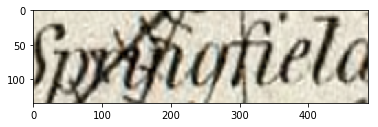

In [15]:
q = np.transpose(images_before[53],(1,2,0))
plt.imshow(q)
plt.show()

q = np.transpose(images_before[64],(1,2,0))
plt.imshow(q)
plt.show()

Correctly classified before and In-correctly classified after
************************************************************************
************************************************************************


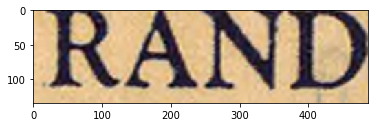

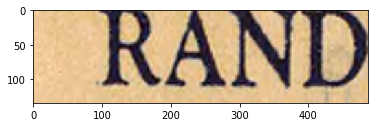

Image Index: 7
Matched before: $RAND$
Matched after:$GRAND$
Ground truth:RAND
Image Dir before:0
Image Dir after:0
Distance before:0.10829245864507309
Distance after:0.09622169171111639

All Distances Before:[('Rand', 0.7275042144232584), ('RAN', 0.2932997516218899), ('RAND', 0.10829245864507309), ('rand', 0.9999999999770379), ('ran', 0.9999999999999986), ('and', 0.9999999999999993), ('Ran', 0.7348354630336764), ('AND', 0.6895902431129337)]

All Distances After:[('Rand', 0.8870279457261152), ('RAN', 0.4549491707252734), ('RAND', 0.25176824591081093), ('rand', 1.0), ('ran', 1.0), ('and', 1.0), ('Ran', 0.8375979866688223), ('AND', 0.5417636103738208)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


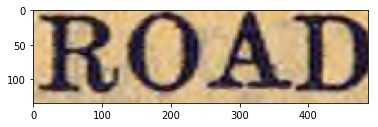

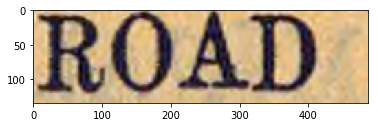

Image Index: 35
Matched before: $ROAD$
Matched after:$ROADS$
Ground truth:ROAD
Image Dir before:0
Image Dir after:0
Distance before:0.04493275979210365
Distance after:0.09829490467879642

All Distances Before:[('OAD', 0.5203355805784673), ('ROAD', 0.04493275979210365), ('ROA', 0.36100736289015234), ('road', 1.0), ('oad', 1.0), ('roa', 1.0), ('Road', 0.7874950500568816), ('Roa', 0.7608772147030605)]

All Distances After:[('OAD', 0.43502070077866273), ('ROAD', 0.2636510297197492), ('ROA', 0.39374795348642233), ('road', 0.9999999999999999), ('oad', 1.0), ('roa', 1.0), ('Road', 0.7951466152557861), ('Roa', 0.771228524266463)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


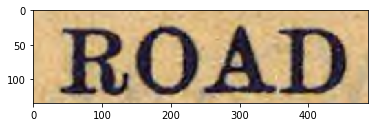

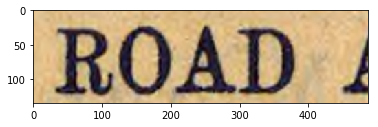

Image Index: 58
Matched before: $ROAD$
Matched after:$ROADS$
Ground truth:ROAD
Image Dir before:0
Image Dir after:0
Distance before:0.03922950368232081
Distance after:0.11301292610552416

All Distances Before:[('OAD', 0.5685192267642363), ('ROAD', 0.03922950368232081), ('ROA', 0.4246899454137679), ('road', 1.0), ('oad', 1.0), ('roa', 1.0), ('Road', 0.7628077166606935), ('Roa', 0.7842588978817406)]

All Distances After:[('OAD', 0.47743926627189914), ('ROAD', 0.2725510597459223), ('ROA', 0.4028833601186401), ('road', 1.0), ('oad', 1.0), ('roa', 1.0), ('Road', 0.7730822590564546), ('Roa', 0.7760492504654564)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


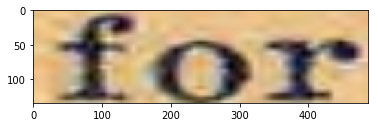

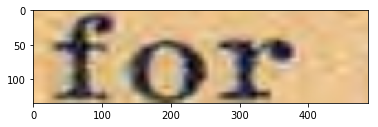

Image Index: 73
Matched before: $for$
Matched after:$fort$
Ground truth:for
Image Dir before:0
Image Dir after:0
Distance before:0.19092463909846935
Distance after:0.32893267033658324

All Distances Before:[('for', 0.19092463909846935), ('For', 0.5729075249458984), ('OR', 0.9483185438848472), ('FO', 0.9908416237973869), ('fo', 0.4382332640270785), ('FOR', 0.946367195485805), ('Fo', 0.8441069806384744), ('or', 0.552163735737222)]

All Distances After:[('for', 0.36953569114141327), ('For', 0.633331303421663), ('OR', 0.9999052495206519), ('FO', 0.9473289985973007), ('fo', 0.5555089741536153), ('FOR', 0.9502520378671829), ('Fo', 0.8353483731661535), ('or', 0.6635178297105617)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


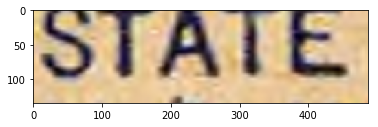

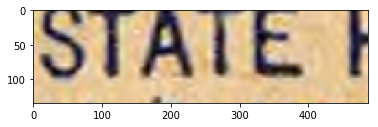

Image Index: 292
Matched before: $STATE$
Matched after:$STATES$
Ground truth:STATE
Image Dir before:0
Image Dir after:0
Distance before:0.3774139070081892
Distance after:0.2698247139736565

All Distances Before:[('tate', 0.9999999999999958), ('STAT', 0.5293855712563604), ('Stat', 0.7624488202752645), ('state', 0.9999999999999998), ('stat', 0.9999999999999998), ('State', 0.7834466234070956), ('STATE', 0.3774139070081892), ('TATE', 0.7354184638998442)]

All Distances After:[('tate', 0.9999999999999941), ('STAT', 0.5222828755802414), ('Stat', 0.7818790115420774), ('state', 0.9999999999999999), ('stat', 0.9999999999999999), ('State', 0.7977409630107868), ('STATE', 0.36715689202132695), ('TATE', 0.5119206580471798)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************

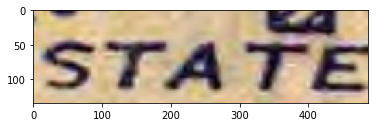

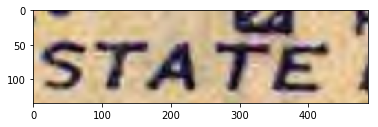

Image Index: 473
Matched before: $STATE$
Matched after:$STATES$
Ground truth:STATE
Image Dir before:0
Image Dir after:0
Distance before:0.0652138557105727
Distance after:0.07310381042772418

All Distances Before:[('tate', 0.9999999999970534), ('STAT', 0.4309135154137511), ('Stat', 0.8050534883576509), ('state', 0.9999999999587833), ('stat', 0.9999999999562504), ('State', 0.8188365623877166), ('STATE', 0.0652138557105727), ('TATE', 0.2697747501069371)]

All Distances After:[('tate', 0.9999999996566752), ('STAT', 0.5898240354762259), ('Stat', 0.7946797085882624), ('state', 0.9999999914480551), ('stat', 0.9999999907977262), ('State', 0.8091917769617706), ('STATE', 0.2867829213350319), ('TATE', 0.2642225667779854)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************

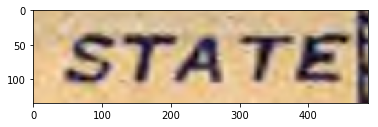

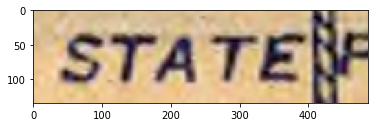

Image Index: 531
Matched before: $STATE$
Matched after:$STATES$
Ground truth:STATE
Image Dir before:0
Image Dir after:0
Distance before:0.04564614847144721
Distance after:0.16742316628617548

All Distances Before:[('tate', 0.9999999999995555), ('STAT', 0.35776201802725327), ('Stat', 0.7798787471910549), ('state', 0.9999999999999724), ('stat', 0.9999999999999702), ('State', 0.8241255323286736), ('STATE', 0.04564614847144721), ('TATE', 0.37010587196294)]

All Distances After:[('tate', 0.9999999999970721), ('STAT', 0.5917970743273294), ('Stat', 0.8049104305654019), ('state', 0.9999999999893336), ('stat', 0.9999999999885225), ('State', 0.8187847262823496), ('STATE', 0.336616918749879), ('TATE', 0.3430327792510962)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************

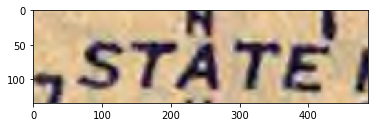

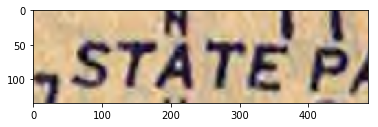

Image Index: 602
Matched before: $STATE$
Matched after:$STATES$
Ground truth:STATE
Image Dir before:0
Image Dir after:0
Distance before:0.08607418081796381
Distance after:0.2468445398861504

All Distances Before:[('tate', 0.9999999788796015), ('STAT', 0.3960854074879796), ('Stat', 0.788918334681046), ('state', 0.9999999999244213), ('stat', 0.9999999999188807), ('State', 0.8374198953919993), ('STATE', 0.08607418081796381), ('TATE', 0.32034975375872443)]

All Distances After:[('tate', 0.9999999999995725), ('STAT', 0.5152319738972864), ('Stat', 0.8157493674314842), ('state', 0.9999999999999835), ('stat', 0.9999999999999822), ('State', 0.8288851279479781), ('STATE', 0.30248510899038383), ('TATE', 0.4314159665348094)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
**********************************************************

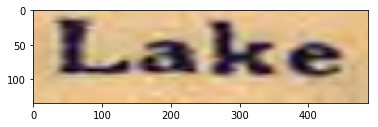

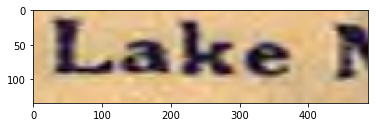

Image Index: 725
Matched before: $Lake$
Matched after:$Lakes$
Ground truth:Lake
Image Dir before:0
Image Dir after:0
Distance before:0.00022751498639195233
Distance after:0.14314470143321245

All Distances Before:[('ake', 0.5496897443782983), ('lak', 0.6252080618864075), ('AKE', 0.9999998573594888), ('Lak', 0.39992918677674094), ('Lake', 0.00022751498639195233), ('LAKE', 0.7481397904885312), ('lake', 0.252074337075338), ('LAK', 0.7747180308238831)]

All Distances After:[('ake', 0.5355653358426977), ('lak', 0.5925473644624436), ('AKE', 0.9999999873328604), ('Lak', 0.33127914843023154), ('Lake', 0.24171241900579166), ('LAKE', 0.7661004795071644), ('lake', 0.47551366235614057), ('LAK', 0.7385853003354023)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
********************************************************************

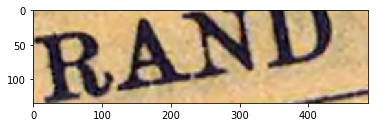

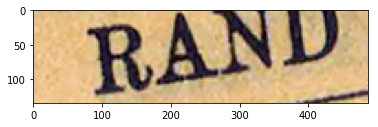

Image Index: 919
Matched before: $RAND$
Matched after:$GRAND$
Ground truth:RAND
Image Dir before:0
Image Dir after:0
Distance before:0.24679869873256954
Distance after:0.192032245899462

All Distances Before:[('Rand', 0.7944477166774051), ('RAN', 0.38698240019416474), ('RAND', 0.24679869873256954), ('rand', 0.9999999999989965), ('ran', 1.0), ('and', 1.0), ('Ran', 0.7701483610570343), ('AND', 0.4365069639125535)]

All Distances After:[('Rand', 0.8136190717540557), ('RAN', 0.276135223549429), ('RAND', 0.22510519768629755), ('rand', 0.9999999891491586), ('ran', 0.9999999987560848), ('and', 0.9999999995548327), ('Ran', 0.7325201926600629), ('AND', 0.579484197476458)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


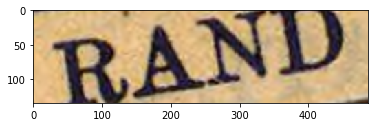

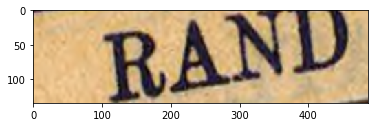

Image Index: 939
Matched before: $RAND$
Matched after:$GRAND$
Ground truth:RAND
Image Dir before:0
Image Dir after:0
Distance before:0.08796072135228405
Distance after:0.12592275651715623

All Distances Before:[('Rand', 0.7307798477702167), ('RAN', 0.31881763151040377), ('RAND', 0.08796072135228405), ('rand', 1.0), ('ran', 1.0), ('and', 1.0), ('Ran', 0.7445593913627695), ('AND', 0.5860891122628131)]

All Distances After:[('Rand', 0.8713533664948734), ('RAN', 0.4055170789703515), ('RAND', 0.21859375630445266), ('rand', 0.9999999999999364), ('ran', 1.0), ('and', 1.0), ('Ran', 0.8138816155041873), ('AND', 0.5126980068062645)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


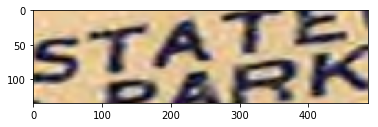

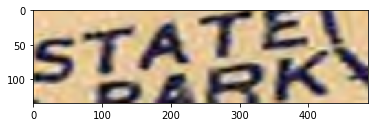

Image Index: 954
Matched before: $STATE$
Matched after:$STATES$
Ground truth:STATE
Image Dir before:0
Image Dir after:0
Distance before:0.33084144791127545
Distance after:0.397184487439008

All Distances Before:[('tate', 0.9999999999999942), ('STAT', 0.4280393196176403), ('Stat', 0.7845325528843816), ('state', 1.0), ('stat', 1.0), ('State', 0.8049249669846045), ('STATE', 0.33084144791127545), ('TATE', 0.5881421890786226)]

All Distances After:[('tate', 1.0), ('STAT', 0.562259348899056), ('Stat', 0.7969701679279226), ('state', 1.0), ('stat', 1.0), ('State', 0.8113222838752672), ('STATE', 0.4594847383744767), ('TATE', 0.5254351892090823)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


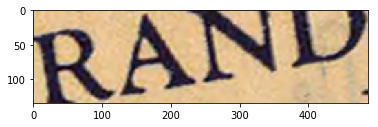

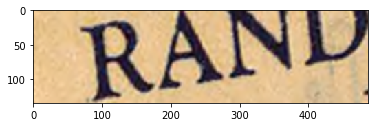

Image Index: 1059
Matched before: $RAND$
Matched after:$GRAND$
Ground truth:RAND
Image Dir before:0
Image Dir after:0
Distance before:0.1804863084303726
Distance after:0.14992039667714885

All Distances Before:[('Rand', 0.7523281888699686), ('RAN', 0.26169938236269663), ('RAND', 0.1804863084303726), ('rand', 1.0), ('ran', 1.0), ('and', 1.0), ('Ran', 0.7231237964493509), ('AND', 0.7217644197726327)]

All Distances After:[('Rand', 0.7979212227858921), ('RAN', 0.3986027867424744), ('RAND', 0.19508875490715882), ('rand', 1.0), ('ran', 1.0), ('and', 1.0), ('Ran', 0.7726642594465927), ('AND', 0.5527523251823147)]
------------------------------------------------------------------------
------------------------------------------------------------------------
13


In [38]:
print "Correctly classified before and In-correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 0:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print "Image Index: " + str(i)
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(words[i])
        print "Image Dir before:" + str(match_report_before[2][i])
        print "Image Dir after:" + str(match_report_after[2][i])
        print "Distance before:" + str(match_report_before[4][i])
        print "Distance after:" + str(match_report_after[4][i])
        print "\nAll Distances Before:" + str(match_report_before[6][i])
        print "\nAll Distances After:" + str(match_report_after[6][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count

## Details
* The above plot shows images that were almost correctly classified before (matched with word variation of the root word) and were mis-classified after we tried to extend them
* The first image corresponds to before extension and second image corresponds to after extension
* Every image's index is printed on the first line after the image. The index is used for heatmap plotting shown above
* The plot aslo mentions other details like, best distance and match before, best distance and match after and distances of the ground truth and its variations before and after

## Current Analysis
* From the above plot it can be seen that distances for ground truth and its variations is changing significantly after the images are extended.
    * For e.g in case of RANDOLPH (index 22), one would expect distance of "RANDOLPH" to come down. But on the contrary, the distance increased
    * But in CAMDEN (index 61) case, although distance of "CAMDEN" came down, distance of "AMDEN" (previous prediction) goes above
* Haven't been able to reach any conclusive results yet

In [24]:
from IPython.display import HTML, display

data = [['before/after','incorrect (0)','correct (1)','almost (2)'],
        ['incorrect (0)',5,6,4],
        ['correct (1)',8,9,2],
        ['almost (2)',8,9,4]]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))

before/after,incorrect (0),correct (1),almost (2)
incorrect (0),5,6,4
correct (1),8,9,2
almost (2),8,9,4
